<style>
@import url('https://fonts.googleapis.com/css2?family=Roboto+Mono:ital@0;1&display=swap');
</style>
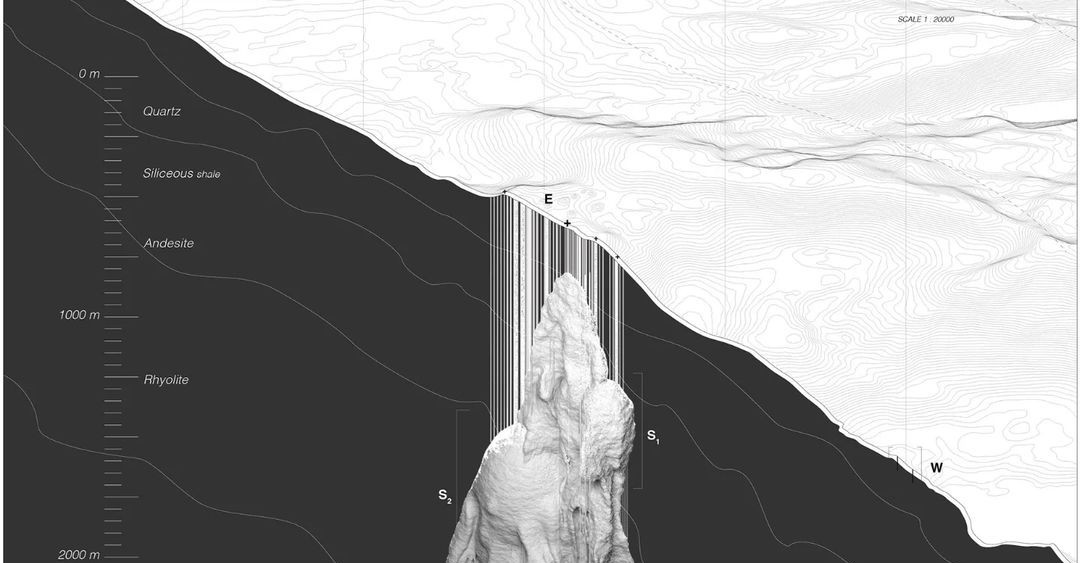

<!-- <a href = 'https://catalog.data.gov/dataset/international-ice-patrol-iip-iceberg-sightings-database-version-1-5ac0b' title = "Dataset Source" style = ""> -->
<h2 style = "font-size: 26px; text-align: center; font-family: 'Roboto Mono', monospace;">International Ice Patrol (IIP) Iceberg Sightings Database, Version 1</h2> 
<!-- </a>  -->

<p style = "text-align: center;">• 𖥔 ࣪˖ ⭑ ₊ 𖥔 *</p>                                               
<p style = "font-size: 20px; text-align: center; font-family: 'Roboto Mono', monospace;">With Linear Regression (ML Learning)</p>
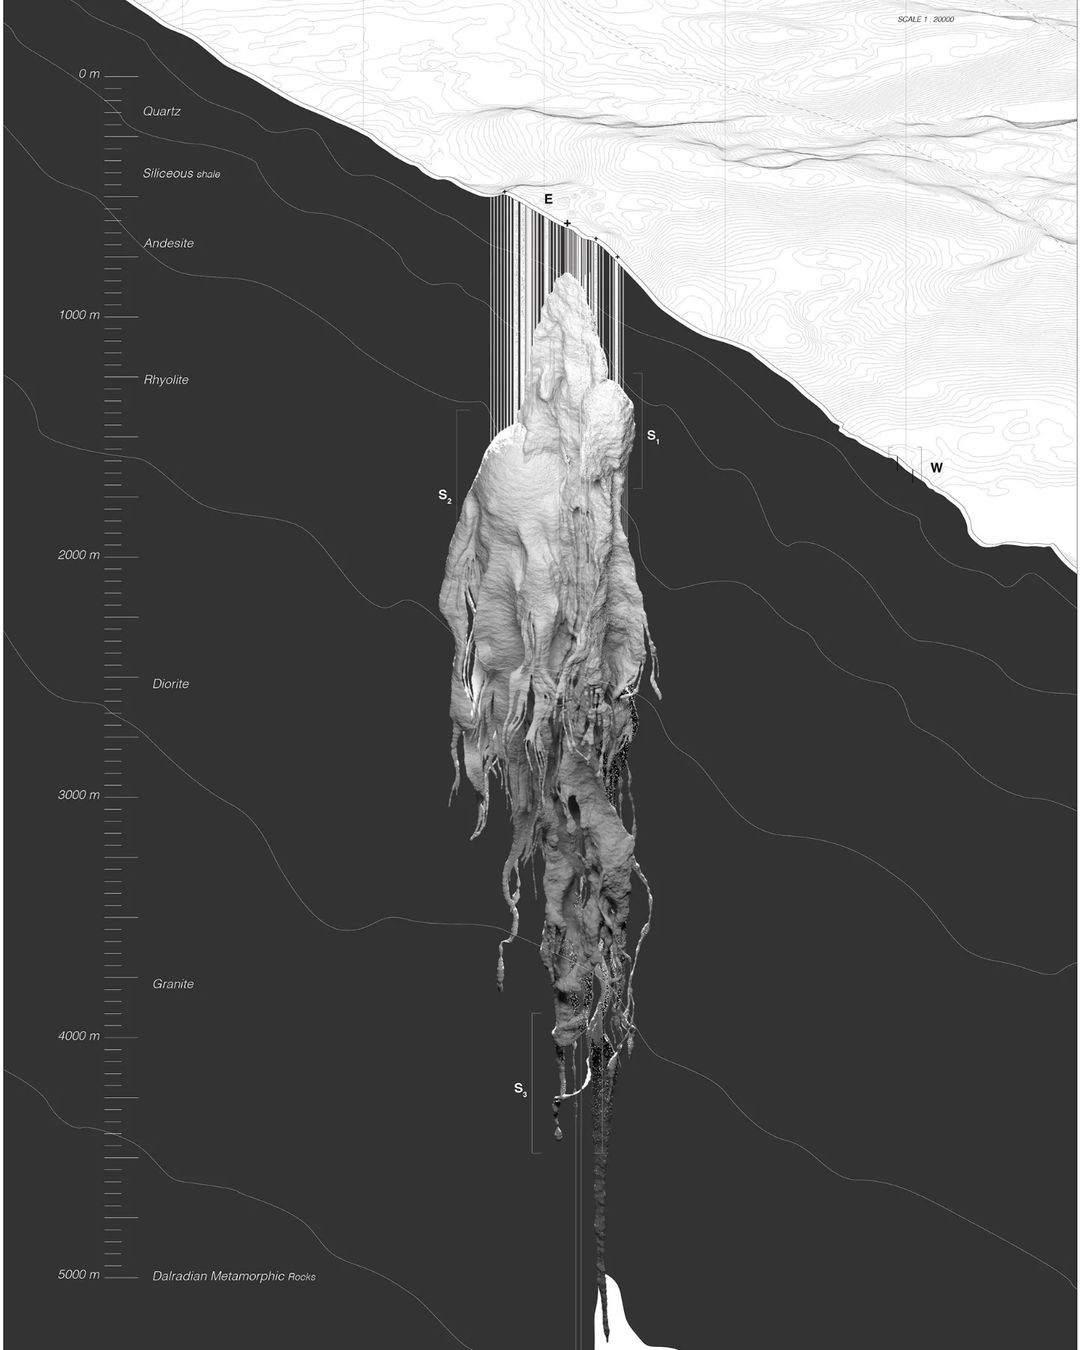
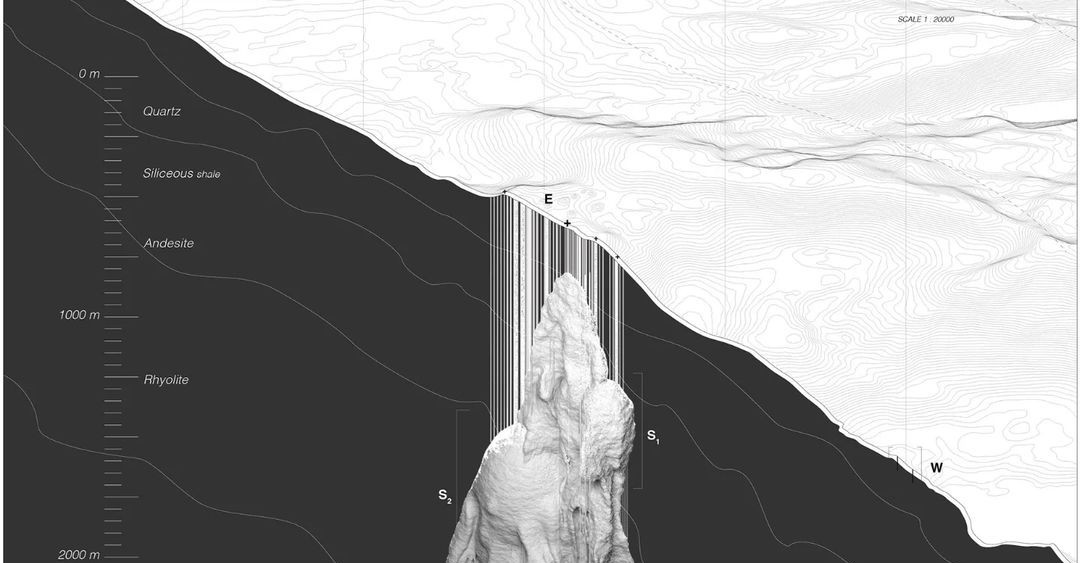

<p style = "font-size: 20px; text-align: center; font-family: 'Roboto Mono', monospace;">======================================================================</p>
<p style = "font-size: 20px; text-align: center; font-family: 'Roboto Mono', monospace;">Developed for Semester 1: Machine Learning, Assessment 1 Exercise 1</p>

In [1]:
# Importing the libraries necessary to make the learning model and visualisations
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import math as math

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

<h2 style = "font-size: 26px; text-align: center; font-family: 'Roboto Mono',monospace;">Preprocessing and Data Scrubbing</h2>
Before loading the .csv file, the dataset has been scaled down in Google Sheets (to reduce the heavy load on the notebook) but has been organized to satisfy the 500+ rows and 5+ features requirements. We're also going to be scrubbing the data by deleting columns and rows to narrow down our hyperparameters. Lastly, we'll be checking for Null values and use Ordinal Encoding on non-numerical categories.

In [2]:
# Describe dataset
data = pd.read_csv("/kaggle/input/iceberg-sightings-dataset/Iceberg Sightings - IIP_2021IcebergSeason.csv")

# Delete unneccessary columns for learning model
data = data.drop(["SIGHTING_DATE","SIGHTING_LATITUDE", "SIGHTING_LONGITUDE"], axis = 1)

#Reduce outliers in data by keeping values at the median 20000+
data = data[data["ICEBERG_NUMBER"] >= 19999]

# Checking for Null values
print("\nMissing values in dataset:", data.isnull().sum().sum())
data = data.dropna()

# Ordinal coding for non-numerical values
ordinal_encoder = OrdinalEncoder()
sighting_method_values = ordinal_encoder.fit_transform(data[["SIGHTING_METHOD"]])
size_values = ordinal_encoder.fit_transform(data[["SIZE"]])
shape_values = ordinal_encoder.fit_transform(data[["SHAPE"]])

print("==================")
print("\nSmall references")
print("Sighting method ordinal keys: 3 = SAT-LOW  2 = SAT-HIGH, 1 = VIS, 0 = R/V")
print("Size ordinal keys: 4 = NTB, 3 = GEN")
print("Shape ordinal keys: 6 = SM, 4 = MED, 3 = LG")

# One Hot Encoding for non-numerical values
# onehot_encoder = OneHotEncoder(sparse=False)
# sighting_method_values = onehot_encoder.fit_transform(data[["SIGHTING_METHOD"]])
# size_values = onehot_encoder.fit_transform(data[["SIZE"]])
# shape_values = onehot_encoder.fit_transform(data[["SHAPE"]])

print(f"\n {data}")


Missing values in dataset: 0

Small references
Sighting method ordinal keys: 3 = SAT-LOW  2 = SAT-HIGH, 1 = VIS, 0 = R/V
Size ordinal keys: 4 = NTB, 3 = GEN
Shape ordinal keys: 6 = SM, 4 = MED, 3 = LG

       ICEBERG_NUMBER  SIGHTING_TIME SIGHTING_METHOD SIZE SHAPE
245            20001           1003         SAT-LOW  GEN   MED
246            20002           1043        SAT-HIGH  GEN   MED
247            20004           1545        SAT-HIGH  NTB   MED
248            20005           1545        SAT-HIGH  NTB    SM
249            20006           1545        SAT-HIGH  NTB    SM
...              ...            ...             ...  ...   ...
1993           20498           1322             R/V  GEN   MED
1994           20499           1322             R/V  GEN   MED
1995           20500           1322             R/V  GEN    LG
1996           20503           1322             R/V  GEN    SM
1997           20504           1322             R/V  GEN    SM

[1749 rows x 5 columns]


In [3]:
data.head() # Check first values

,ICEBERG_NUMBER,SIGHTING_TIME,SIGHTING_METHOD,SIZE,SHAPE
245,20001,1003,SAT-LOW,GEN,MED
246,20002,1043,SAT-HIGH,GEN,MED
247,20004,1545,SAT-HIGH,NTB,MED
248,20005,1545,SAT-HIGH,NTB,SM
249,20006,1545,SAT-HIGH,NTB,SM


In [4]:
data.tail() # Check last values

,ICEBERG_NUMBER,SIGHTING_TIME,SIGHTING_METHOD,SIZE,SHAPE
1993,20498,1322,R/V,GEN,MED
1994,20499,1322,R/V,GEN,MED
1995,20500,1322,R/V,GEN,LG
1996,20503,1322,R/V,GEN,SM
1997,20504,1322,R/V,GEN,SM


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1749 entries, 245 to 1997
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ICEBERG_NUMBER   1749 non-null   int64 
 1   SIGHTING_TIME    1749 non-null   int64 
 2   SIGHTING_METHOD  1749 non-null   object
 3   SIZE             1749 non-null   object
 4   SHAPE            1749 non-null   object
dtypes: int64(2), object(3)
memory usage: 82.0+ KB


In [6]:
# Cannot scale data because the dataframe is unchanged, 
# the ordinal encoded values are copied into seperate variables

# scaler = MinMaxScaler()
# data[data.columns[1:]] = scaler.fit_transform(data[data.columns[1:]])

<p style = "font-size: 20px; font-family: 'Roboto Mono', monospace;">Splitting Data</p>
Before developing the training model, I've set aside the features that are going to influence the outcome of our training model

In [7]:
# Chosen features
X = data[["SIGHTING_TIME"]]
X2 = sighting_method_values 
X3 = size_values
X4 = shape_values

# Outcome values
Y = data[["ICEBERG_NUMBER"]]

# Shape of values (Ensure each shape is the same 'size' to prevent ValueError)
print('\nSighting time values:', X.shape)
print('\nSighting method values:', X2.shape)
print('\nIceberg size values:', X3.shape)
print('\nIceberg shape values:', X4.shape)


Sighting time values: (1749, 1)

Sighting method values: (1749, 1)

Iceberg size values: (1749, 1)

Iceberg shape values: (1749, 1)


In [8]:
X = np.array([[X,X2,X3,X4]], dtype=object) # Values have diverse data types, array is assigned object
X = X.reshape(X.shape[1:]) # Remove extra dimensions to array
X = X.transpose()          # To make sure X and Y are of equal samples
X = X.reshape(X.shape[1:]) # Remove remaining dimensions

# Once properly organized, split X and Y values to individual (80%) train and (20%) test variables
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2)

In [9]:
print(X_train)
print(Y_train)

[[947 2.0 3.0 4.0]
 [1452 2.0 3.0 4.0]
 [1002 2.0 3.0 3.0]
 ...
 [1931 0.0 4.0 4.0]
 [1913 0.0 4.0 3.0]
 [956 3.0 3.0 4.0]]
      ICEBERG_NUMBER
1417           20218
887            20089
1341           20415
627            20198
971            20270
...              ...
434            20090
1698           20482
1656           20214
348            20068
1826           20335

[1399 rows x 1 columns]


<p style = "font-size: 20px; font-family: 'Roboto Mono', monospace;">Model Training</p>
In this part, we're finally going to create the Linear Regression ML model and then plug in the training data that will form the basis of our future predictions.

In [10]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

<h2 style = "font-size: 26px; text-align: center; font-family: 'Roboto Mono',monospace;">Model Predictions</h2>

In [11]:
Y_predict = model.predict(X_test)
count = 0

print("Predicted results of Linear Regression model:")
for i in Y_predict:
    count += 1
    for y in i:
        print(f"{count} {y:.2f}") # Round each result into 2dp (decimal point)

Predicted results of Linear Regression model:
1 20204.53
2 20209.65
3 20203.81
4 20264.50
5 20217.76
6 20204.53
7 20245.86
8 20236.74
9 20162.74
10 20182.25
11 20243.01
12 20266.45
13 20214.23
14 20203.81
15 20263.67
16 20264.90
17 20243.01
18 20214.23
19 20148.15
20 20263.10
21 20201.26
22 20168.00
23 20210.37
24 20209.65
25 20236.48
26 20124.30
27 20250.58
28 20243.01
29 20230.37
30 20248.85
31 20248.85
32 20242.43
33 20229.13
34 20202.70
35 20203.81
36 20210.37
37 20255.62
38 20250.00
39 20249.42
40 20263.10
41 20250.00
42 20248.85
43 20264.50
44 20250.58
45 20268.28
46 20264.47
47 20268.28
48 20210.37
49 20205.18
50 20263.02
51 20229.13
52 20243.77
53 20182.25
54 20209.91
55 20263.67
56 20268.86
57 20209.65
58 20162.74
59 20210.37
60 20242.43
61 20214.75
62 20257.26
63 20202.99
64 20273.26
65 20249.42
66 20212.57
67 20209.65
68 20269.36
69 20252.82
70 20250.50
71 20264.50
72 20264.83
73 20187.08
74 20250.65
75 20209.65
76 20258.41
77 20187.95
78 20151.95
79 20235.47
80 20223.45
81 

In [12]:
# Ridge Regression scores
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,Y_train)

train_score_ridge = ridge_reg.score(X_train, Y_train)
test_score_ridge = ridge_reg.score(X_test, Y_test)

print(f"\nRidge Regression training score: {train_score_ridge:.4f}")
print(f"\nRidge Regression testing score: {test_score_ridge:.4f}\n")

print("=======================================")
# Lasso Regression scores
lasso_reg = Lasso(alpha = 10)
lasso_reg.fit(X_train,Y_train)

train_score_lasso = lasso_reg.score(X_train,Y_train)
test_score_lasso = lasso_reg.score(X_test,Y_test)

ridge_y_predict = ridge_reg.predict(X_test)
lasso_y_predict = lasso_reg.predict(X_test)

print(f"\nLasso Regression training score: {train_score_lasso:.4f}")
print(f"\nLasso Regression testing score: {test_score_lasso:.4f}\n")


Ridge Regression training score: 0.0518

Ridge Regression testing score: 0.0620


Lasso Regression training score: 0.0400

Lasso Regression testing score: 0.0483



<h2 style = "font-size: 26px; text-align: center; font-family: 'Roboto Mono',monospace;">Visualisations</h2>
Below are visualisations of data using the X/Y normal values, viewing the overall differences between the dataset's values and the machine learning's outcomes through some examples between variable pairs.


Actual values of the dataset without train/test split



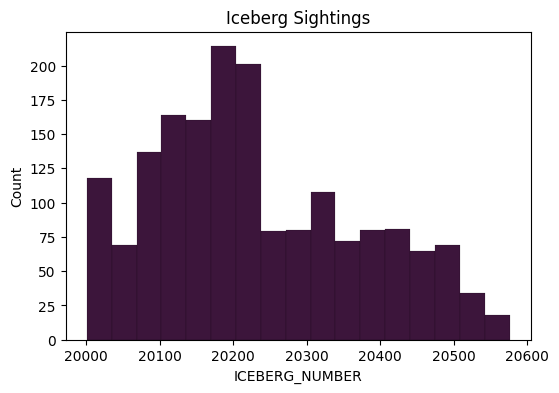

In [13]:
import seaborn as sns
print("\nActual values of the dataset without train/test split\n")
plt.figure(figsize=(6,4))
data_range = data['ICEBERG_NUMBER']
sns.histplot(data['ICEBERG_NUMBER'], facecolor = "#3C153B", linewidth = 0.1) # Initial Y values
plt.title('Iceberg Sightings')
plt.show()


Iceberg number values of test data



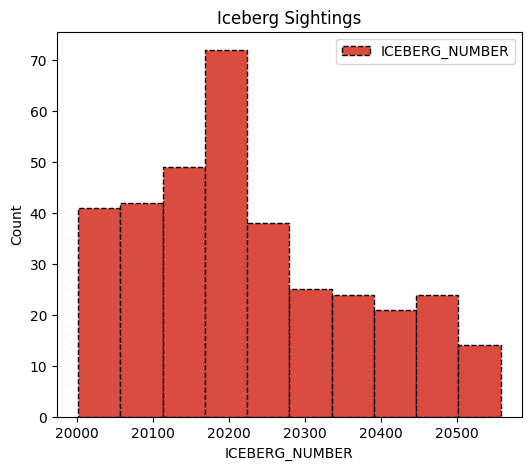

In [14]:
print("\nIceberg number values of test data\n")
plt.figure(figsize=(6,5))
sns.histplot(Y_test, facecolor = "#DB4C40", linestyle = "--") # Initial Y values
plt.title('Iceberg Sightings')
plt.xlabel('ICEBERG_NUMBER')
plt.show()

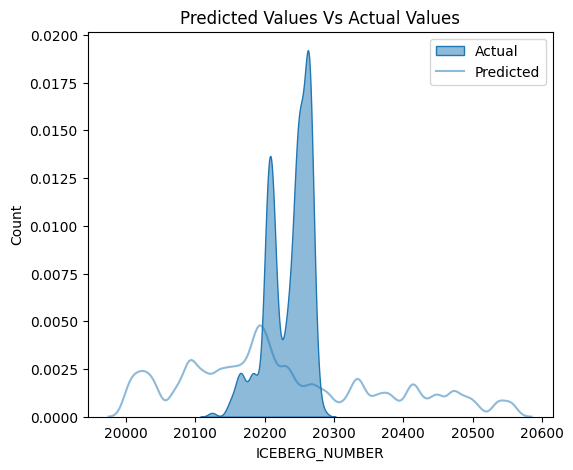

In [15]:
plt.figure(figsize=(6, 5))

sns.kdeplot(Y_predict, label='Actual', fill=True, alpha=0.5, bw_adjust=.6)
sns.kdeplot(Y_test, label='Predicted', alpha=0.5, bw_adjust=.2)
plt.xlabel('ICEBERG_NUMBER')
plt.title("Predicted Values Vs Actual Values")
plt.ylabel('Count')

plt.legend()

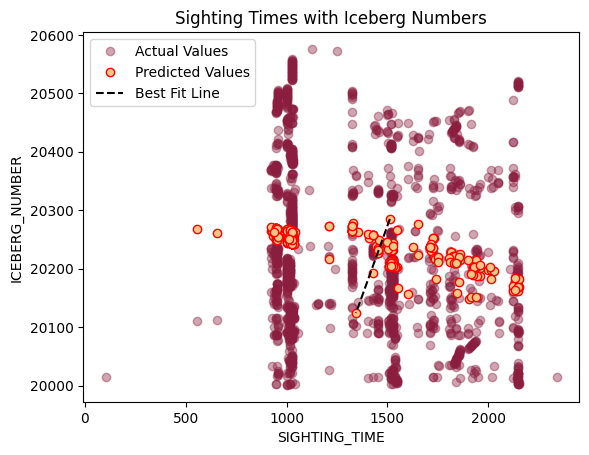

In [16]:
# Create scatter plot with hyperplane

# Seperate values as lists for inputting data points for on scatter plot
sighting_time = []
iceberg_numbers = []

# Test values with Predicted values
sighting_time_predictions = []
iceberg_numbers_predictions = []

for i in data["SIGHTING_TIME"]:
    sighting_time.append(i)

for i in data["ICEBERG_NUMBER"]:
    iceberg_numbers.append(i)

for i in X_test:
    sighting_time_predictions.append(i[0])

for i in Y_predict:
    iceberg_numbers_predictions.append(i[0])

# Iceberg Numbers Y axis
point1_y = max(iceberg_numbers_predictions)
point2_y = min(iceberg_numbers_predictions)
point1_index = iceberg_numbers_predictions.index(max(iceberg_numbers_predictions))
point2_index = iceberg_numbers_predictions.index(min(iceberg_numbers_predictions))

# Sighting Time X axis
point1_x = sighting_time_predictions[point1_index]
point2_x = sighting_time_predictions[point2_index]

# Create points
line1 = [point1_x, point2_x]
line2 = [math.floor(point1_y), math.floor(point2_y)]

plt.plot(sighting_time, iceberg_numbers, 'co', color = "#8B1E3F", alpha = 0.4)
plt.plot(sighting_time_predictions, iceberg_numbers_predictions, 'co', color = "#F0C987",
        markeredgecolor='red')
plt.plot(line1, line2, color='black', linestyle = "--")

plt.title("Sighting Times with Iceberg Numbers")
plt.xlabel('SIGHTING_TIME')
plt.ylabel('ICEBERG_NUMBER')
plt.legend(['Actual Values', 'Predicted Values', 'Best Fit Line'])
plt.show()

Plotted test values: [20190, 20197, 20183, 20201, 20171, 20250]
Plotted predicted values: [20204, 20209, 20203, 20264, 20217, 20204]


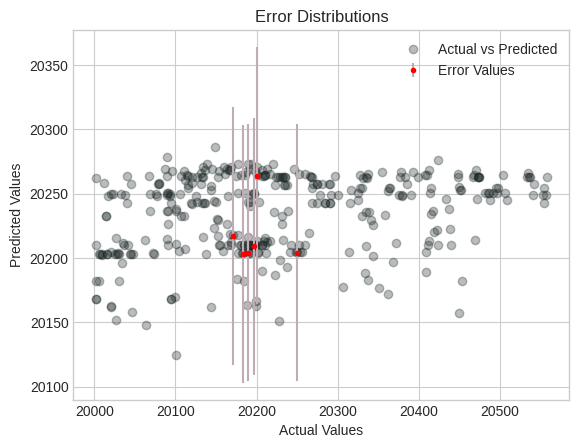

In [17]:
# Instantiating lists to prevent Value error
Y_test_values = []
Y_predict_values = []

# Error value roughly referenced from MAE
errorvalue = 100

count = 0
count2 = 0

Y_test = np.array(Y_test, dtype = "object")

# Sample size of five test values vs. five predicted values
for i in Y_test: 
    for x in i:
        Y_test_values.append(x)
    count2 += 1
    if count2 > 5:
        break

for i in Y_predict:
    for x in i:
        Y_predict_values.append(math.floor(x))
    count += 1
    if count > 5:
        break
        
# Values inputted in graph
print(f"Plotted test values: {Y_test_values}")
print(f"Plotted predicted values: {Y_predict_values}")

# Plotting error graph for error distribution
plt.style.use('seaborn-whitegrid')
plt.title("Error Distributions")
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values")
plt.plot(Y_test, Y_predict, 'o', color = "#172121", alpha = 0.3)
plt.errorbar(Y_test_values, Y_predict_values, yerr = errorvalue, fmt = ".k", 
             ecolor='#BFACB5', color = "red", capsize = 0)
plt.legend(['Actual vs Predicted', 'Error Values'])
plt.show()

<h2 style = "font-size: 26px; text-align: center; font-family: 'Roboto Mono',monospace;">Evaluation and Conclusions</h2>
<p style = "text-align: center;">• 𖥔 ࣪˖ ⭑ ₊ 𖥔 *</p>

In [18]:
# Linear Regression Scores
# The unit differences between actual values and the predicted values
print("\n==========================")
print("\n Linear Regression Scores")
mae = mean_absolute_error(Y_test, Y_predict)
print(f"\n The Mean Absolute Error score: {mae:.2f}")

# Shows averages of squared errors for optimization purposes (focuses on value deviations)
mse = mean_squared_error(Y_test, Y_predict)
print(f"\n The Mean Squared Error score: {mse:.2f}")

# Showcases how well predicted values are based on the proportion of variance of initial test values
r2 = r2_score(Y_test, Y_predict)
print(f"\n Root Mean Squared Error (RMSE): {r2:.2f}\n")

# Ridge Regression Scores
mae = mean_absolute_error(Y_test, ridge_y_predict)
print("\n==========================")
print("\n Ridge Regression Scores")
print(f"\n The Mean Absolute Error score: {mae:.2f}")
mse = mean_squared_error(Y_test, ridge_y_predict)
print(f"\n The Mean Squared Error score: {mse:.2f}")
r2 = r2_score(Y_test, ridge_y_predict)
print(f"\n Root Mean Squared Error (RMSE): {r2:.2f}\n")

# Lasso Regression Scores
print("\n==========================")
print("\n Lasso Regression Scores")
mae = mean_absolute_error(Y_test, lasso_y_predict)
print(f"\n The Mean Absolute Error score: {mae:.2f}")
mse = mean_squared_error(Y_test, lasso_y_predict)
print(f"\n The Mean Squared Error score: {mse:.2f}")
r2 = r2_score(Y_test, lasso_y_predict)
print(f"\n Root Mean Squared Error (RMSE): {r2:.2f}\n")



 Linear Regression Scores

 The Mean Absolute Error score: 114.91

 The Mean Squared Error score: 19185.66

 Root Mean Squared Error (RMSE): 0.06



 Ridge Regression Scores

 The Mean Absolute Error score: 114.91

 The Mean Squared Error score: 19185.64

 Root Mean Squared Error (RMSE): 0.06



 Lasso Regression Scores

 The Mean Absolute Error score: 115.39

 The Mean Squared Error score: 19464.81

 Root Mean Squared Error (RMSE): 0.05



**Dataset description**
The dataset I've borrowed is from [data.gov](https://catalog.data.gov/dataset/international-ice-patrol-iip-iceberg-sightings-database-version-1-5ac0b), recording iceberg sightings done by the International Ice Patrol across the North Atlantic. It details (from left-to-right) the year, number, dates, (military) time, latitude, longitude, sighting methods, size, shape and sources, of these iceberg sightings. It initially had 6,000+ rows of numerical and non-numerical values spanning these 9 features.

**Preprocessing** 
After obtaining the dataset, I've 'scaled' the size down by 60% in Google Sheets to verify a small (but feasible) sample size. I've deleted irrelevant features like the 'ICEBERG_YEAR' and 'SOURCE' columns before relinquishing the data scrubbing to the PANDAS library using .drop(). This prevents tampering of the original source file and allows for versatile manipulation of its values for the learning model. 'SIGHTING_LATITUDE', 'SIGHTING_LONGITUDE' and 'SIGHTING_DATE' were also dropped due to their irrelevancy. A .isnull() check was also done to ensure there are no Null values. Encoding was done using ordinal encoding for non-numerical categories since the Linear Regression model works with numerical values. I've also lowered the range of my data to 20,000+ iceberg sightings using a condition, as there are large cases of outlier values that have no gradual numerical ascent (and are all over the place).

**Model Implementation**
I've combined every feature variable using .reshape() and .transpose() to a single X variable in order to combine them into a complex array, ultimately splitting them into 80% training and 20% testing without having to call multiple lines to split these features and call them in the .fit() parameters. As for the Y variables, it was pretty straightforward as I only referenced the number of icebergs.

**Results**
Results of the model's outputted values followed a pattern of 'decrease'. There's a 60%-70% prediction accuracy score according to the r2 score and a 100+ units margin between the actual values taken from the outcome variable training data vs. the testing data. 

**Interpretation**
I wanted to discover and experiment the possibility of a non-traditional relationship between independent and dependent variables. Obviously, not every feature influences the nature of iceberg appearances but how investigators alike perceived these values. For example, in figure 4 'Sighting Times with Iceberg Numbers', there's a denser quantity and greater number of icebergs spotted in 1000 hours of the morning. The actual values plotted on the graph show a decline of iceberg spottings later in the hours of the evening, this same pattern can be seen in the predicted values of our learning model. 

Judging from the predicted values, that there is a case of underfitting where there is less variance in values outputted (which cannot follow the original values of the dataset) and there is a high bias towards a certain range of iceberg numbers (the highest value can only go up to around 20,350 where the highest actual values can go up to 20,500). As a test, I've switched to the original datasheet to produce more results, however, it has proved to induce larger margins of error.

To conclude, my hypothesis has not been satisfied because the features available in this dataset are not entirely appropriate for Linear Regression, but could very well work with Logistical Regression, in determining the quantity of icebergs; however with what has been available, I've managed to uncover a directly proportionate relationship between timings and number of spotted icebergs.